In [1]:
%matplotlib inline
# Load the "autoreload" extension
%load_ext autoreload
# always reload modules
%autoreload 2
# black formatter for jupyter notebooks
# %load_ext nb_black
# black formatter for jupyter lab
%load_ext lab_black

%run ../../src/notebook_env.py


---------------------------------
Working on the host: imarevic-pc

---------------------------------
Python version: 3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:20:04) [GCC 11.3.0]

---------------------------------
Python interpreter: /home/imarevic/anaconda3/envs/srh/bin/python3.10


# Random Forest

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    confusion_matrix,
    accuracy_score,
    ConfusionMatrixDisplay,
)
from sklearn.preprocessing import StandardScaler

Wir haben in den vorherigen Kapiteln sehr viel über Entscheidungsbäume und Wege zur Optimierung dieser (z.B, Bagging und Boosting) gelernt. Dieses Wissen bietet im Prinzip schon das gesamte wichitge ab, dass wir verstehen müssen um <a href="https://de.wikipedia.org/wiki/Random_Forest">Random Forests</a> zu verstehen und anwenden zu können. Dieses Kapitel wird daher ei sehr kurzes, da wir die Grundlagen hierfür schon in den vorherigen beiden Kapiteln erarbeitet haben.

Random Forests bieten gegenüber Bagging die Vorteile, dass die Entscheidungsbäume, die an die Daten gefittet werden und über deren Vorhersagen am Ende "gebagged" (gemittelt) wird, **dekorrelierte** Bäume sind. Was bedeutet jedoch dekorreliert?

Dekorrelierte Bäume werden bei Random Forests erzeugt, indem bei jeder Iteration nur ein Bruchteil der Prädiktoren im Trainingsdatensatz verwendet werden. Lassen Sie uns ein Beispiel machen: Nehmen wir an wir haben einen Datensatz mit den 5 Prädiktoren A, B, C, D, und E. Wenn wir einfaches Baggin durchführen, dann würden wir alle 5 Prädiktoren in jeder Iteration $B$ des Bagging-Verfahrens verwenden. Wenn nun aber der Prädiktor C ein sehr guter Prädiktor im Vergleich zu den anderen ist, dann würde dies bedeuten, dass wir $B$ sehr stark korrelierte Bäume als Modell trainiert haben und die resultierenden Bäume sich sehr ähneln werden. Daher wird bei Random Forests immer nur ein Bruchteil $m \approx \sqrt p$ der insgesamt zur Verfügung stehenden $p$ Prädiktoren imTraining verwendet. Dies stellt somit sicher, dass kein dominantre Prädiktor in jedem Baum, der in den $B$ Iterationen trainiert wurde vorkommt, und somit die Bäume **dekorreliert** sind.

## Feature Importance

Da wir bei Random Forests immer nur einen Teil der Prädiktoren verwenden, lässt sich die **Feature Importance**, also die Güte hinsichtlich jedes Prädiktors abschätzen. Dies geschieht in dem der Abfall der Summe der Fehlerquadrate (SSE), oder ein anderes Fehlermaß, über alle gebaggten Entscheidungsbäume in Abhängigkeit der Splits und Prädiktoren, die in jedem Split vorhanden waren berechnet wird. Als Maß für die Feature Importance wird häufig der **Mean Impurity Index (MDI)** verwendet. Dieser ist in `scikit-learn` als Feature Importance Algorithmus für Random Forests implementiert und berechnet sich wie folgt:

1. Für jeden Entscheidunsbaum und Knoten im Entschediungsbaum berechne die **Gini-Impurity G**:
$$
G = 1 - \sum_{i=1}^k (p_{i}²)
$$

    mit $k$ die Anzahl Kategorien in die gesplitted wurde und $p_{i}$ der Anteil Beobachtungen die zur Kategorie $i$ an dem Knoten gehören.
    
2. Die Gini-Impurity wird einmal für den gesamten Entscheidungsbaum und alle Bäume im Forest berechnet. Diese wird $G_{initial}$ genannt.
3. Die Gini-Impurity wird dann für jeden Knoten bei dem ein Feature/Prädiktor involviert war ebenfalls berechnet. Für Features $F_{1}, F_{2}, F_{3}, ..., F{n}$ wird also separat jeweils respektive ein $G_{F_{1}}, G_{F_{2}}, G_{F_{3}}, ..., G_{F_{n}},$ berechnet.
4.  Im Anschluss wird dann für jedes Feature die Differenz $D_{reduction}$ zur initialen Gini-Impurity $G_{initial}$ berechnet, sodass 

$$
D_{reduction} = G_{initial} - G_{F_{i}}, \forall  i \in \{1, 2, 3, ..., N\}
$$

5. Zuletzt wird dann über alle Bäume un Knoten die MDI berechnet:

$$
MDI = \frac {\sum_{i={F_{1}}}^{F_{N}} D_{reduction}}{N_{features}}
$$


In der folgenden Implementierung werden wir sehen, wie wir die Feature Importance für jeden Prädiktor für Random Forests ausgeben und plotten können.

## Random Forests in Python

Im Folgenden werden wir Random Forests mit Hilfe der `scikit-learn` Bibliothek in Python implementieren. Wir werden uns hier auf den Ragressionsfall beschränken, der Klassifikationsfall funktionert jedoch analog.

In [3]:
data = pd.read_csv("../../data/hitters.csv")
data = data.dropna()
data.head(5)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [4]:
# Enkodierung der Daten
data = pd.get_dummies(data, drop_first=True)

#  Features und Target definieren
X_df = data.drop("Salary", axis=1)
y_df = data["Salary"]
X = X_df.values
y = y_df.values

# Standartisierung der Daten
scaler_X = StandardScaler()
X_standardized = scaler_X.fit_transform(X)
scaler_y = StandardScaler()
y_standardized = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Splitten der Daten in train, validatio und test set
X_train, X_temp, y_train, y_temp = train_test_split(
    X_standardized, y_standardized, test_size=0.4, random_state=42
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

In [5]:
# Model Training
regr_rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
regr_rf.fit(X_train, y_train)

# Vorhersage neuer Beobachtungen
y_rf = regr_rf.predict(X_test)

# MSE
mse = mean_squared_error(y_test, y_rf)
print("The mean squared error (MSE) auf den Testdaten: {:.4f}".format(mse))

The mean squared error (MSE) auf den Testdaten: 0.7893


Zuletzt werden wir die Feature Importance ausgeben um zu inspizieren, welche der Prädiktoren die meiste Varianz im Model aufklären:

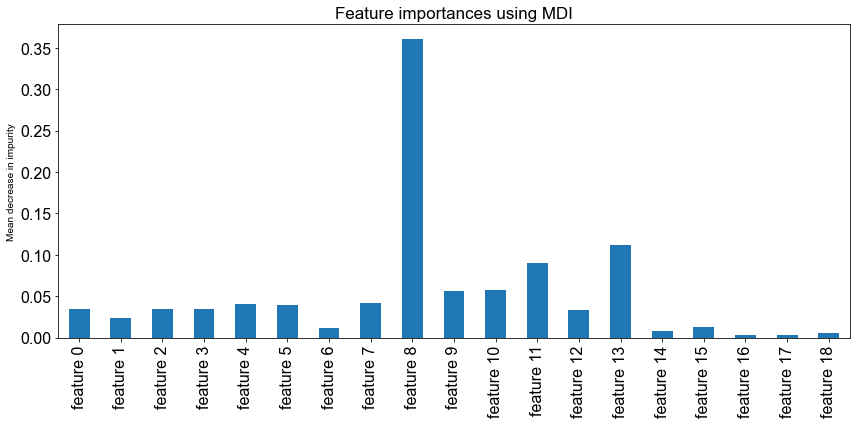

In [7]:
# Extraktion der Feature Importances aus dem Model Objekt
importances = regr_rf.feature_importances_

# Feature Namen und STD werden generiert
feature_names = [f"feature {i}" for i in range(X_test.shape[1])]
forest_importances = pd.Series(importances, index=feature_names)
std = np.std([regr_rf.feature_importances_ for tree in regr_rf.estimators_], axis=0)

# Plotten der Feature Importance
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Da wir die Prädiktoren im Vorfeld dummy-kodiert haben, sehen wir nun genau diese im Plot. Es ist deutlich zu erkennen, dass`feature 8` die höchste Varianzaufklärung besitzt, gefolgt von `feature 13` und `feature 11`. Das bedeutet, dass ein Model mit nur den Features mit höchster Feature Importance sehr wahrscheinlich ausreichend wäre, und die anderen Features keinen prädiktiven Mehrwert haben. 